# Anomaly Detection in a time series.

### **Implementation in webserver request time in LTH's moodle server**

1. Dependencies

In [1]:
#!pip install tensorflow

In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
RANDOM_SEED = 2021 
TEST_PCT = 0.3

2. Reading the data

In [3]:
dataset = pd.read_csv("876.csv")
dataset

,timestamp,unix-epoch,value
0,2022-06-01 18:47:03.625346+00,1.654109e+09,78.480000
1,2022-06-01 18:49:03.826399+00,1.654109e+09,135.917031
2,2022-06-01 18:48:04.301765+00,1.654109e+09,74.639130
3,2022-06-01 18:46:04.039116+00,1.654109e+09,157.000000
4,2022-06-01 18:50:04.552654+00,1.654109e+09,118.517699
...,...,...,...
434877,2023-03-31 14:13:04.101678+00,1.680272e+09,104.783784
434878,2023-03-31 14:24:03.918018+00,1.680273e+09,44.647059
434879,2023-03-31 14:21:03.492804+00,1.680272e+09,107.304878
434880,2023-03-31 14:19:03.269547+00,1.680272e+09,67.820513


### 3. Preprocessing the data

### 3.1 Checking for nulls

In [4]:
# Check for any  nullvalues 
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')

# Check for outliers
mean = dataset['value'].mean()
sd = dataset['value'].std()
print(mean + 3 * sd)
dataset = dataset[dataset['value'] <= mean + 3 * sd]

Any nulls in the dataset  False
-------
988.4450353119108


### 3.2 Reshaping the data

First we sort them chronologically

In [5]:
# Sorting by time
df = dataset.sort_values('unix-epoch')
print(df)

                            timestamp    unix-epoch       value
6       2022-06-01 16:21:03.721533+00  1.654100e+09   73.074380
11      2022-06-01 16:22:04.254788+00  1.654101e+09   68.822115
14      2022-06-01 16:23:03.887237+00  1.654101e+09   70.881279
10      2022-06-01 16:24:04.474149+00  1.654101e+09   88.367742
12      2022-06-01 16:25:04.012942+00  1.654101e+09   69.131068
...                               ...           ...         ...
434875  2023-03-31 14:20:03.954358+00  1.680272e+09  107.853403
434879  2023-03-31 14:21:03.492804+00  1.680272e+09  107.304878
434881  2023-03-31 14:22:03.652436+00  1.680273e+09   71.783133
434872  2023-03-31 14:23:04.355078+00  1.680273e+09   76.673267
434878  2023-03-31 14:24:03.918018+00  1.680273e+09   44.647059

[434439 rows x 3 columns]


Then we group them by minute precision taking the mean if there are more than one tuple of said minute.

In [6]:
# Convert 'unix-epoch' column to datetime
df['datetime'] = pd.to_datetime(df['unix-epoch'], unit='s')

df = df[["datetime", "value"]]

df = df.resample("1Min", on="datetime").mean()

df = df.reset_index()
print(df)

                  datetime       value
0      2022-06-01 16:21:00   73.074380
1      2022-06-01 16:22:00   68.822115
2      2022-06-01 16:23:00   70.881279
3      2022-06-01 16:24:00   88.367742
4      2022-06-01 16:25:00   69.131068
...                    ...         ...
436199 2023-03-31 14:20:00  107.853403
436200 2023-03-31 14:21:00  107.304878
436201 2023-03-31 14:22:00   71.783133
436202 2023-03-31 14:23:00   76.673267
436203 2023-03-31 14:24:00   44.647059

[436204 rows x 2 columns]


In [7]:

df['hour'] = df['datetime'].dt.floor('H')

df

,datetime,value,hour
0,2022-06-01 16:21:00,73.074380,2022-06-01 16:00:00
1,2022-06-01 16:22:00,68.822115,2022-06-01 16:00:00
2,2022-06-01 16:23:00,70.881279,2022-06-01 16:00:00
3,2022-06-01 16:24:00,88.367742,2022-06-01 16:00:00
4,2022-06-01 16:25:00,69.131068,2022-06-01 16:00:00
...,...,...,...
436199,2023-03-31 14:20:00,107.853403,2023-03-31 14:00:00
436200,2023-03-31 14:21:00,107.304878,2023-03-31 14:00:00
436201,2023-03-31 14:22:00,71.783133,2023-03-31 14:00:00
436202,2023-03-31 14:23:00,76.673267,2023-03-31 14:00:00


Then we check which hours have enough tuples to consider them on the model.

In [8]:
# Create boolean mask to filter out groups with less than 30 tuples
mask = df.groupby('hour')['value'].transform('count') >= 30

# Filter DataFrame using the mask
df = df[mask]

df

,datetime,value,hour
0,2022-06-01 16:21:00,73.074380,2022-06-01 16:00:00
1,2022-06-01 16:22:00,68.822115,2022-06-01 16:00:00
2,2022-06-01 16:23:00,70.881279,2022-06-01 16:00:00
3,2022-06-01 16:24:00,88.367742,2022-06-01 16:00:00
4,2022-06-01 16:25:00,69.131068,2022-06-01 16:00:00
...,...,...,...
436174,2023-03-31 13:55:00,48.444444,2023-03-31 13:00:00
436175,2023-03-31 13:56:00,58.716535,2023-03-31 13:00:00
436176,2023-03-31 13:57:00,84.803571,2023-03-31 13:00:00
436177,2023-03-31 13:58:00,40.194805,2023-03-31 13:00:00


We now interpolate

In [9]:
df = df.set_index("datetime")

# Perform interpolation to fill missing values
df['value'] = df['value'].interpolate()

df = df.reset_index()

df['day'] = df['datetime'].dt.floor('D')

df

,datetime,value,hour,day
0,2022-06-01 16:21:00,73.074380,2022-06-01 16:00:00,2022-06-01
1,2022-06-01 16:22:00,68.822115,2022-06-01 16:00:00,2022-06-01
2,2022-06-01 16:23:00,70.881279,2022-06-01 16:00:00,2022-06-01
3,2022-06-01 16:24:00,88.367742,2022-06-01 16:00:00,2022-06-01
4,2022-06-01 16:25:00,69.131068,2022-06-01 16:00:00,2022-06-01
...,...,...,...,...
434794,2023-03-31 13:55:00,48.444444,2023-03-31 13:00:00,2023-03-31
434795,2023-03-31 13:56:00,58.716535,2023-03-31 13:00:00,2023-03-31
434796,2023-03-31 13:57:00,84.803571,2023-03-31 13:00:00,2023-03-31
434797,2023-03-31 13:58:00,40.194805,2023-03-31 13:00:00,2023-03-31


We check to see how many days have hours missing

In [10]:
hour_df = df.groupby("hour").count()
hour_df = hour_df.reset_index()
hour_df = hour_df.sort_values('hour')



hour_df['day'] = hour_df['hour'].dt.floor('D')
day_df = hour_df.groupby('day').count()
day_df = day_df.reset_index()
day_df = day_df.sort_values('value')
day_df

,day,hour,datetime,value
0,2022-06-01,8,8,8
303,2023-03-31,12,12,12
280,2023-03-08,17,17,17
281,2023-03-09,18,18,18
282,2023-03-10,18,18,18
...,...,...,...,...
100,2022-09-09,24,24,24
99,2022-09-08,24,24,24
98,2022-09-07,24,24,24
96,2022-09-05,24,24,24


In [11]:
day_df[:15]

,day,hour,datetime,value
0,2022-06-01,8,8,8
303,2023-03-31,12,12,12
280,2023-03-08,17,17,17
281,2023-03-09,18,18,18
282,2023-03-10,18,18,18
284,2023-03-12,23,23,23
198,2022-12-16,23,23,23
205,2022-12-23,24,24,24
204,2022-12-22,24,24,24
203,2022-12-21,24,24,24


### Making a moving window dataset.

In [12]:
import datetime

window_size = 120

# Create an empty list to store the arrays
arrays = []
initial_dates = []

# Iterate through the DataFrame
for i in range(len(df) - window_size):
    # Check if the indices are 30 numbers away
    if df.index[i+window_size] - df.index[i] == window_size:
        # Extract the values for the consecutive tuples
        values = df['value'].iloc[i:i+window_size].values
        # Append the values to the list
        arrays.append(values)
        initial_dates.append(df['datetime'].values[i])

# Convert the list of arrays to a NumPy array
arrays = np.array(arrays)

print(arrays)


  # if df_filtered[i]['datetime'] - df_filtered[i + 30]['datetime'] == datetime.timedelta(minutes=window_size):
  #   correct_windows.append(df_filtered[i:i+30]['value'])

[[73.07438  68.822115 70.881279 ... 83.678571 88.45614  78.231156]
 [68.822115 70.881279 88.367742 ... 88.45614  78.231156 94.921212]
 [70.881279 88.367742 69.131068 ... 78.231156 94.921212 72.951613]
 ...
 [26.760563 46.727273 48.514286 ... 72.9      48.444444 58.716535]
 [46.727273 48.514286 97.808081 ... 48.444444 58.716535 84.803571]
 [48.514286 97.808081 66.732394 ... 58.716535 84.803571 40.194805]]


In [13]:
print(arrays.shape)

(434679, 120)


## 4. Training the model

4.1 We split the data with a 20% rate.

In [14]:
data = arrays

#train_data, test_data, train_indices, test_indices = train_test_split(
#    data, np.arange(len(data)), test_size=0.2, random_state=2021
#)

train_data, test_data = np.split(data, [int(0.8* len(data))])
train_indices, test_indices = np.split(np.arange(len(data)), [int(0.8* len(data))])

In [15]:
test_indices

array([347743, 347744, 347745, ..., 434676, 434677, 434678])

In [16]:
train_data.shape

(347743, 120)

We take them to values from 0 to 1

In [17]:
print(test_data[1][:10])

[  0.   0.   0.   0. 111.   9.  72.   0.   8.   0.]


In [18]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [19]:
train_data

<tf.Tensor: shape=(347743, 120), dtype=float32, numpy=
array([[0.07399143, 0.06968579, 0.0717708 , ..., 0.0847287 , 0.08956622,
        0.07921292],
       [0.06968579, 0.0717708 , 0.08947671, ..., 0.08956622, 0.07921292,
        0.09611242],
       [0.0717708 , 0.08947671, 0.06999863, ..., 0.07921292, 0.09611242,
        0.07386712],
       ...,
       [0.        , 0.        , 0.00860667, ..., 0.        , 0.        ,
        0.07492866],
       [0.        , 0.00860667, 0.        , ..., 0.        , 0.07492866,
        0.        ],
       [0.00860667, 0.        , 0.        , ..., 0.07492866, 0.        ,
        0.00877543]], dtype=float32)>

In [20]:
nb_epoch = 50
batch_size = 32
input_dim = train_data.shape[1] #num of columns, 30
encoding_dim = 50
hidden_dim_1 = 24
hidden_dim_2 = 10
hidden_dim_3 = 4  
learning_rate = 1e-4

In [21]:
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="relu", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_3, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='relu')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 dense (Dense)               (None, 50)                6050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                1224      
                                                                 
 dense_2 (Dense)             (None, 10)                250       
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
 dense_5 (Dense)             (None, 24)                120   

In [22]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=20,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [23]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [24]:
from keras.models import load_model



history = autoencoder.fit(train_data, train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_data, test_data),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/50
10824/10867 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.0131
Epoch 1: val_loss improved from inf to 0.00097, saving model to autoencoder_fraud.h5
10867/10867 [==============================] - 8s 675us/step - loss: 0.0016 - accuracy: 0.0131 - val_loss: 9.7143e-04 - val_accuracy: 0.0156
Epoch 2/50
  255/10867 [..............................] - ETA: 6s - loss: 0.0015 - accuracy: 0.0165 

/Users/domingocarvajal/.pyenv/versions/3.10.4/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10835/10867 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.0186
Epoch 2: val_loss improved from 0.00097 to 0.00097, saving model to autoencoder_fraud.h5
10867/10867 [==============================] - 7s 639us/step - loss: 0.0015 - accuracy: 0.0186 - val_loss: 9.6820e-04 - val_accuracy: 0.0233
Epoch 3/50
10816/10867 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.0253
Epoch 3: val_loss did not improve from 0.00097
10867/10867 [==============================] - 7s 639us/step - loss: 0.0015 - accuracy: 0.0253 - val_loss: 0.0010 - val_accuracy: 0.0302
Epoch 4/50
10866/10867 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.0302
Epoch 4: val_loss did not improve from 0.00097
10867/10867 [==============================] - 7s 641us/step - loss: 0.0015 - accuracy: 0.0302 - val_loss: 0.0010 - val_accuracy: 0.0334
Epoch 5/50
10834/10867 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.0330
Epoch 5: val_

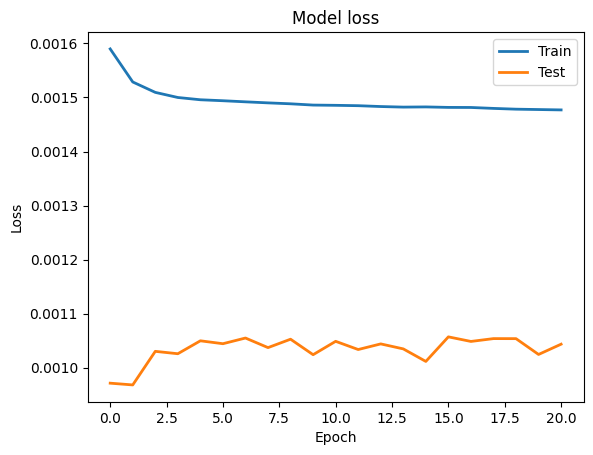

In [25]:
try:
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Test')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    # plt.ylim(ymin=0.70,ymax=1)
    plt.show()
except NameError as e:
    print("MOdel is trained")

In [26]:
# from keras.models import load_model
# auto_encoder = load_model('/content/autoencoder_fraud.h5')

In [27]:
print(test_data[1][:200])

tf.Tensor(
[0.         0.         0.         0.         0.11239299 0.00911294
 0.07290356 0.         0.0081004  0.         0.         0.
 0.         0.         0.         0.01113804 0.         0.
 0.         0.01417569 0.         0.         0.         0.
 0.         0.02025099 0.         0.         0.00243494 0.00084772
 0.         0.         0.         0.         0.01350066 0.0081004
 0.         0.         0.         0.         0.00877543 0.00843791
 0.         0.         0.11036789 0.13365653 0.01779194 0.
 0.00776288 0.         0.0060753  0.         0.00877543 0.
 0.         0.         0.         0.         0.         0.
 0.         0.00945046 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00776288 0.         0.         0.0287564  0.04603206 0.
 0.         0.         0.         0.         0.         0.
 0.01965005 0.06017437 0.0081004  0.         0.00708785 0.13770673
 0.         0.         0.04799484 0.04910865 0.         0.0313890

In [28]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
test_labels = np.full((mse.shape), False)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})
print(f"Mean Squared Error: {mse}")
error_df

2717/2717 [==============================] - 1s 267us/step
Mean Squared Error: [0.00071256 0.00073331 0.00072856 ... 0.0043616  0.00433746 0.00430151]


,Reconstruction_error,True_class
0,0.000713,False
1,0.000733,False
2,0.000729,False
3,0.000726,False
4,0.000720,False
...,...,...
86931,0.004462,False
86932,0.004450,False
86933,0.004362,False
86934,0.004337,False


In [29]:
train_x_predictions = autoencoder.predict(train_data)
mse = np.mean(np.power(train_data - train_x_predictions, 2), axis=1)
train_labels = np.full((mse.shape), False)
train_error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': train_labels})
print(f"Mean Squared Error: {mse}")
train_error_df

10867/10867 [==============================] - 3s 266us/step
Mean Squared Error: [0.00051437 0.00052075 0.00052553 ... 0.00070686 0.00072041 0.0007108 ]


,Reconstruction_error,True_class
0,0.000514,False
1,0.000521,False
2,0.000526,False
3,0.000528,False
4,0.000522,False
...,...,...
347738,0.000688,False
347739,0.000684,False
347740,0.000707,False
347741,0.000720,False


In [30]:
print(test_x_predictions[1])
print(test_data[1])

[0.00885776 0.00912518 0.00689945 0.01106116 0.00785051 0.00847021
 0.01079878 0.00924227 0.00840593 0.00819509 0.00815309 0.00640566
 0.00426987 0.00660857 0.00588493 0.00595425 0.00558367 0.00837898
 0.00855035 0.00542435 0.00801468 0.00574719 0.00443129 0.00961359
 0.00678949 0.00731677 0.0077714  0.00738505 0.00449261 0.0089721
 0.00468238 0.01022694 0.00962455 0.00741334 0.00847624 0.00926939
 0.00839709 0.00973129 0.00953196 0.01037117 0.00771163 0.00680301
 0.00734144 0.00567305 0.00840161 0.00960903 0.00797051 0.00850749
 0.00810449 0.01198764 0.00949792 0.01230663 0.00656943 0.01008394
 0.00781448 0.00835546 0.00836604 0.00833917 0.00960162 0.00948397
 0.01650344 0.00993242 0.01185641 0.01130209 0.01426852 0.00986118
 0.0100694  0.01202464 0.01061041 0.01057075 0.01114647 0.01196519
 0.01173914 0.00949301 0.01063309 0.00950865 0.01040261 0.01175468
 0.01268069 0.00845644 0.00955544 0.01431486 0.01043744 0.01176981
 0.00942707 0.00759441 0.01177862 0.0135949  0.01153545 0.01183

In [31]:
quantile_value = 0.95

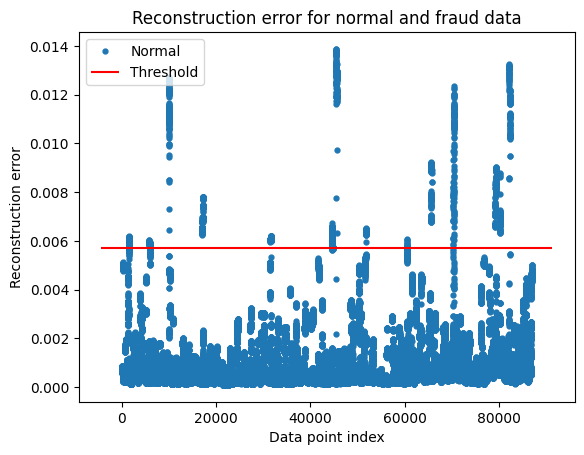

In [32]:
groups = error_df.groupby('True_class')
threshold = train_error_df['Reconstruction_error'].quantile(quantile_value)
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [33]:
error_df['Reconstruction_error'].quantile(quantile_value)

0.002996357448864728

In [34]:
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y

In [35]:
anomalies_df = error_df[error_df['pred'] == 1]
non_anomalies_df = error_df[error_df['pred']==0]
anomalies_df

,Reconstruction_error,True_class,pred
1427,0.005818,False,1
1428,0.005800,False,1
1429,0.005911,False,1
1430,0.005848,False,1
1431,0.005960,False,1
...,...,...,...
82296,0.010270,False,1
82297,0.010308,False,1
82298,0.010371,False,1
82299,0.009476,False,1


In [36]:
anomalies_df["Reconstruction_error"].values

array([0.00581777, 0.00579978, 0.00591148, ..., 0.01037099, 0.00947602,
       0.00946567], dtype=float32)

In [37]:
# Get the indices from anomalies_df
anomaly_indices = anomalies_df.index.values
non_anomaly_indices = non_anomalies_df.index.values

# Find the intersection between test_indices and anomaly_indices
matching_indices = []
na_matching_indices = []
for index in anomaly_indices:
    matching_indices.append(test_indices[index])
matching_indices = np.array(matching_indices)
print(matching_indices.shape)

for index in non_anomaly_indices:
    na_matching_indices.append(test_indices[index])
na_matching_indices = np.array(na_matching_indices)

# Get the values from df_filtered corresponding to matching_indices
matching_values = df.loc[matching_indices, 'datetime'].values
# Get the values from df_filtered corresponding to matching_indices
na_matching_values = df.loc[na_matching_indices, 'datetime'].values

# Print the matching datetime values
print(matching_values)


(1344,)
['2023-01-30T04:51:00.000000000' '2023-01-30T04:52:00.000000000'
 '2023-01-30T04:53:00.000000000' ... '2023-03-28T04:42:00.000000000'
 '2023-03-28T04:43:00.000000000' '2023-03-28T04:44:00.000000000']


In [38]:
anomalies_dates_df = pd.DataFrame({'original_index': matching_indices, 'datetime': matching_values, 'error_value': anomalies_df["Reconstruction_error"].values})
anomalies_dates_df = anomalies_dates_df.sort_values("error_value", ascending=False)
anomalies_dates_df

non_anomalies_dates_df = pd.DataFrame({'original_index': na_matching_indices, 'datetime': na_matching_values, 'error_value': non_anomalies_df["Reconstruction_error"].values})
non_anomalies_dates_df = non_anomalies_dates_df.sort_values("error_value", ascending=True)

# 5. Ploting the anomalies

In [39]:
df['day'] = df['datetime'].dt.floor('D')
df

,datetime,value,hour,day
0,2022-06-01 16:21:00,73.074380,2022-06-01 16:00:00,2022-06-01
1,2022-06-01 16:22:00,68.822115,2022-06-01 16:00:00,2022-06-01
2,2022-06-01 16:23:00,70.881279,2022-06-01 16:00:00,2022-06-01
3,2022-06-01 16:24:00,88.367742,2022-06-01 16:00:00,2022-06-01
4,2022-06-01 16:25:00,69.131068,2022-06-01 16:00:00,2022-06-01
...,...,...,...,...
434794,2023-03-31 13:55:00,48.444444,2023-03-31 13:00:00,2023-03-31
434795,2023-03-31 13:56:00,58.716535,2023-03-31 13:00:00,2023-03-31
434796,2023-03-31 13:57:00,84.803571,2023-03-31 13:00:00,2023-03-31
434797,2023-03-31 13:58:00,40.194805,2023-03-31 13:00:00,2023-03-31


In [40]:


if not os.path.exists("images"):
    os.mkdir("images")
    
if not os.path.exists("normal_images"):
    os.mkdir("normal_images")


In [41]:
#!pip install -U kaleido

In [42]:
import plotly.express as px

hours_graphed = []

for i in range(len(matching_indices)):
    ap = anomalies_dates_df['original_index'].values[i] #Anomaly Point
    time = anomalies_dates_df['datetime'].values[i]
    x0 = time
    x1 = time + pd.DateOffset(hours = window_size / 60)
    hour = df['hour'].values[ap]
    if hour not in hours_graphed:
        hours_graphed.append(hour)
        prediction = autoencoder.predict(data[ap:ap+1])
        df_to_graph = df[df['hour'].between(hour - pd.DateOffset(hours = 2), hour + pd.DateOffset(hours = 2))]
        df_to_graph['prediction'] = ""
            # Find the index corresponding to the specified time
        index = df_to_graph[df_to_graph['datetime'] == time].index[0]

        df_to_graph.loc[index:index+window_size - 1, 'prediction'] = prediction[0]
        fig = px.line(df_to_graph, x='datetime', y="value", log_y=False)
        fig.add_scatter(x=df_to_graph['datetime'], y=df_to_graph['prediction'], name="prediction")
        fig.update_yaxes(ticklabelposition="inside top", title='Webserver request time (ms)')

        fig.add_vrect(x0=str(x0), x1=str(x1), annotation_text="", annotation_position="top left",
                  fillcolor="red", opacity=0.25, line_width=0)
        fig.write_image(f"images/fig{i + 1}.pdf")
        
        fig = px.line(df_to_graph, x='datetime', y="value", log_y=True)
        fig.add_scatter(x=df_to_graph['datetime'], y=df_to_graph['prediction'], name="prediction")
        fig.update_yaxes(ticklabelposition="inside top", title='Webserver request time (ms)')

        fig.add_vrect(x0=str(x0), x1=str(x1), annotation_text="", annotation_position="top left",
                  fillcolor="red", opacity=0.25, line_width=0)
        fig.write_image(f"images/fig{i + 1}log.pdf")
        # fig.show()
        print(time)


1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_graph['prediction'] = ""


2023-03-01T19:26:00.000000000
1/1 [==============================] - 0s 8ms/step
2023-03-28T03:12:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-01T20:10:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-28T02:48:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-05T04:08:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-01T18:59:00.000000000
1/1 [==============================] - 0s 8ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-19T21:41:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-19T22:26:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-05T03:19:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-28T04:00:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-05T02:59:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-16T15:08:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-26T02:14:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-26T01:59:00.000000000
1/1 [==============================] - 0s 8ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-26T17:09:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-16T14:35:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-26T03:07:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-02-10T03:04:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-10T02:57:00.000000000
1/1 [==============================] - 0s 8ms/step
2023-03-26T18:31:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-19T23:01:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-16T13:59:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-26T19:03:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-01T04:32:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-10T01:58:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-06T02:42:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-06T03:03:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-01-30T05:19:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-20T02:48:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-01-30T06:10:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-01T05:17:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-02-20T03:01:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-03-01T03:59:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-13T01:36:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-02T06:23:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-01-30T04:57:00.000000000
1/1 [==============================] - 0s 7ms/step


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-02T07:02:00.000000000
1/1 [==============================] - 0s 7ms/step
2023-03-13T00:13:00.000000000


/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/4071116608.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
hours_graphed = []
for i in range(100):
    ap = non_anomalies_dates_df['original_index'].values[i] #Anomaly Point
    time = non_anomalies_dates_df['datetime'].values[i]
    x0 = time
    x1 = time + pd.DateOffset(hours = window_size / 60)
    hour = df['hour'].values[ap]
    if hour not in hours_graphed:
        hours_graphed.append(hour)
        prediction = autoencoder.predict(data[ap:ap+1])
        df_to_graph = df[df['hour'].between(hour - pd.DateOffset(hours = 2), hour + pd.DateOffset(hours = 2))]
        df_to_graph['prediction'] = ""
            # Find the index corresponding to the specified time
        index = df_to_graph[df_to_graph['datetime'] == time].index[0]
        print(df_to_graph)

        df_to_graph.loc[index:index+window_size - 1, 'prediction'] = prediction[0]
        fig = px.line(df_to_graph, x='datetime', y="value", log_y=False)
        fig.add_scatter(x=df_to_graph['datetime'], y=df_to_graph['prediction'], name="prediction")
        fig.update_yaxes(ticklabelposition="inside top", title='Webserver request time (ms)')

        fig.add_vrect(x0=str(x0), x1=str(x1), annotation_text="", annotation_position="top left",
                  fillcolor="green", opacity=0.25, line_width=0)
        fig.write_image(f"normal_images/fig{i + 1}.pdf")
        
        fig = px.line(df_to_graph, x='datetime', y="value", log_y=True)
        fig.add_scatter(x=df_to_graph['datetime'], y=df_to_graph['prediction'], name="prediction")
        fig.update_yaxes(ticklabelposition="inside top", title='Webserver request time (ms)')

        fig.add_vrect(x0=str(x0), x1=str(x1), annotation_text="", annotation_position="top left",
                  fillcolor="green", opacity=0.25, line_width=0)
        fig.write_image(f"normal_images/fig{i + 1}log.pdf")
        # fig.show()
        print(time)

1/1 [==============================] - 0s 7ms/step
                  datetime      value                hour        day   
370179 2023-02-13 19:00:00  36.928571 2023-02-13 19:00:00 2023-02-13  \
370180 2023-02-13 19:01:00  39.352941 2023-02-13 19:00:00 2023-02-13   
370181 2023-02-13 19:02:00  45.298969 2023-02-13 19:00:00 2023-02-13   
370182 2023-02-13 19:03:00  51.048387 2023-02-13 19:00:00 2023-02-13   
370183 2023-02-13 19:04:00  12.273196 2023-02-13 19:00:00 2023-02-13   
...                    ...        ...                 ...        ...   
370474 2023-02-13 23:55:00  38.333333 2023-02-13 23:00:00 2023-02-13   
370475 2023-02-13 23:56:00  34.538462 2023-02-13 23:00:00 2023-02-13   
370476 2023-02-13 23:57:00  34.857143 2023-02-13 23:00:00 2023-02-13   
370477 2023-02-13 23:58:00  40.800000 2023-02-13 23:00:00 2023-02-13   
370478 2023-02-13 23:59:00  18.000000 2023-02-13 23:00:00 2023-02-13   

       prediction  
370179             
370180             
370181             
3701

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/3681164813.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-13T21:00:00.000000000
1/1 [==============================] - 0s 7ms/step
                  datetime      value                hour        day   
370119 2023-02-13 18:00:00  28.250000 2023-02-13 18:00:00 2023-02-13  \
370120 2023-02-13 18:01:00  45.077922 2023-02-13 18:00:00 2023-02-13   
370121 2023-02-13 18:02:00  30.508929 2023-02-13 18:00:00 2023-02-13   
370122 2023-02-13 18:03:00  31.500000 2023-02-13 18:00:00 2023-02-13   
370123 2023-02-13 18:04:00  54.625000 2023-02-13 18:00:00 2023-02-13   
...                    ...        ...                 ...        ...   
370414 2023-02-13 22:55:00  23.666667 2023-02-13 22:00:00 2023-02-13   
370415 2023-02-13 22:56:00  25.222222 2023-02-13 22:00:00 2023-02-13   
370416 2023-02-13 22:57:00  28.777778 2023-02-13 22:00:00 2023-02-13   
370417 2023-02-13 22:58:00  10.377358 2023-02-13 22:00:00 2023-02-13   
370418 2023-02-13 22:59:00  27.500000 2023-02-13 22:00:00 2023-02-13   

       prediction  
370119             
370120        

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/3681164813.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-13T20:59:00.000000000
1/1 [==============================] - 0s 7ms/step
                  datetime      value                hour        day   
369039 2023-02-13 00:00:00  67.038462 2023-02-13 00:00:00 2023-02-13  \
369040 2023-02-13 00:01:00  56.666667 2023-02-13 00:00:00 2023-02-13   
369041 2023-02-13 00:02:00  34.846154 2023-02-13 00:00:00 2023-02-13   
369042 2023-02-13 00:03:00  47.363636 2023-02-13 00:00:00 2023-02-13   
369043 2023-02-13 00:04:00  41.794872 2023-02-13 00:00:00 2023-02-13   
...                    ...        ...                 ...        ...   
369334 2023-02-13 04:55:00   0.000000 2023-02-13 04:00:00 2023-02-13   
369335 2023-02-13 04:56:00   0.000000 2023-02-13 04:00:00 2023-02-13   
369336 2023-02-13 04:57:00   0.000000 2023-02-13 04:00:00 2023-02-13   
369337 2023-02-13 04:58:00   0.000000 2023-02-13 04:00:00 2023-02-13   
369338 2023-02-13 04:59:00   0.000000 2023-02-13 04:00:00 2023-02-13   

       prediction  
369039             
369040        

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/3681164813.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-13T02:25:00.000000000
1/1 [==============================] - 0s 7ms/step
                  datetime      value                hour        day   
369819 2023-02-13 13:00:00  51.988636 2023-02-13 13:00:00 2023-02-13  \
369820 2023-02-13 13:01:00  53.253623 2023-02-13 13:00:00 2023-02-13   
369821 2023-02-13 13:02:00  64.760274 2023-02-13 13:00:00 2023-02-13   
369822 2023-02-13 13:03:00  53.671329 2023-02-13 13:00:00 2023-02-13   
369823 2023-02-13 13:04:00  36.415000 2023-02-13 13:00:00 2023-02-13   
...                    ...        ...                 ...        ...   
370114 2023-02-13 17:55:00  37.323529 2023-02-13 17:00:00 2023-02-13   
370115 2023-02-13 17:56:00  36.140351 2023-02-13 17:00:00 2023-02-13   
370116 2023-02-13 17:57:00  46.931034 2023-02-13 17:00:00 2023-02-13   
370117 2023-02-13 17:58:00  25.950000 2023-02-13 17:00:00 2023-02-13   
370118 2023-02-13 17:59:00  26.901099 2023-02-13 17:00:00 2023-02-13   

       prediction  
369819             
369820        

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/3681164813.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-13T15:27:00.000000000
1/1 [==============================] - 0s 8ms/step
                  datetime      value                hour        day   
369639 2023-02-13 10:00:00  45.258741 2023-02-13 10:00:00 2023-02-13  \
369640 2023-02-13 10:01:00  52.834951 2023-02-13 10:00:00 2023-02-13   
369641 2023-02-13 10:02:00  54.666667 2023-02-13 10:00:00 2023-02-13   
369642 2023-02-13 10:03:00  65.420635 2023-02-13 10:00:00 2023-02-13   
369643 2023-02-13 10:04:00  46.990338 2023-02-13 10:00:00 2023-02-13   
...                    ...        ...                 ...        ...   
369934 2023-02-13 14:55:00  42.586538 2023-02-13 14:00:00 2023-02-13   
369935 2023-02-13 14:56:00  40.031646 2023-02-13 14:00:00 2023-02-13   
369936 2023-02-13 14:57:00  41.018987 2023-02-13 14:00:00 2023-02-13   
369937 2023-02-13 14:58:00  41.042553 2023-02-13 14:00:00 2023-02-13   
369938 2023-02-13 14:59:00  33.539535 2023-02-13 14:00:00 2023-02-13   

       prediction  
369639             
369640        

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/3681164813.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/l0t8hty96mb527z2jtf6b75r0000gn/T/ipykernel_38945/3681164813.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-02-13T13:06:00.000000000
